In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Chinese Liquor stocks

### Sichuan Swellfun Co.,Ltd (Small Cap)

In [5]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600779.SS_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-24    14.078787  14.004494 -39.930588 -2698175.0     2.0
1  2000-01-25    14.727272  14.115691  -3.361342  2489423.0     2.0
2  2000-01-26    14.787878  14.219104 -35.135148  7249607.0     2.0
3  2000-01-27    14.284848  14.229219 -57.567561  4991464.0     2.0
4  2000-01-28    14.412121  14.257357 -51.891890  7816168.0     2.0


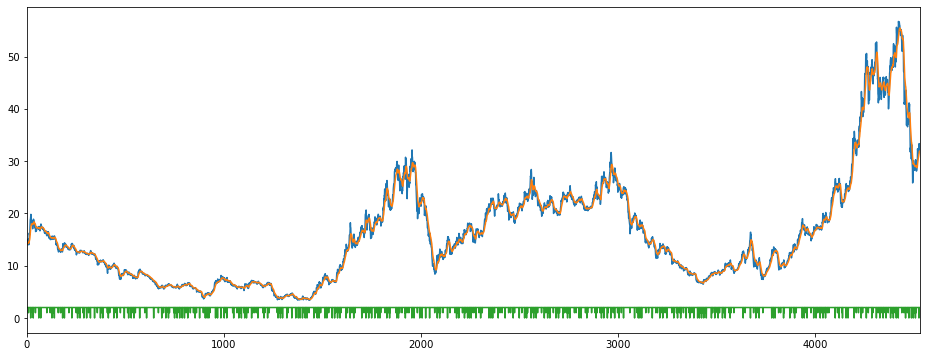

In [6]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [7]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-24,14.078787,14.004494,-39.930588,-2698175.0,2.0
2000-01-25,14.727272,14.115691,-3.361342,2489423.0,2.0
2000-01-26,14.787878,14.219104,-35.135148,7249607.0,2.0
2000-01-27,14.284848,14.229219,-57.567561,4991464.0,2.0
2000-01-28,14.412121,14.257357,-51.891890,7816168.0,2.0


In [8]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [9]:
willr_data = np.array(willr_data)
willr_data.shape

(4517, 15, 1)

In [10]:
price_data = np.array(price_data)
price_data.shape

(4517, 15, 1)

In [11]:
ema_data = np.array(ema_data)
ema_data.shape

(4517, 15, 1)

In [12]:
obv_data = np.array(obv_data)
obv_data.shape

(4517, 15, 1)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [14]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4517, 64, 64, 1)

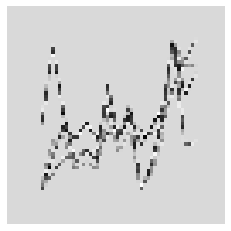

In [15]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [16]:
X = X/255

In [17]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [18]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [19]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [21]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.3885480572597135, 1: 7.3885480572597135, 2: 0.36639286076462835}
Epoch 1/200
 1/29 [>.............................] - ETA: 0s - loss: 0.5035 - accuracy: 0.6641 - mse: 5.6232 - weighted_accuracy: 0.2659 - weighted_mse: 6.2282WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
29/29 [==============================] - 1s 23ms/step - loss: 0.2365 - accuracy: 0.3742 - mse: 1.5555 - weighted_accuracy: 0.3509 - weighted_mse: 1.5904 - val_loss: 0.2045 - val_accuracy: 0.0465 - val_mse: 1.0277 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 1.0277
Epoch 2/200
29/29 [==============================] - 0s 9ms/step - loss: 0.2067 - accuracy: 0.4838 - mse: 1.1906 - weighted_accuracy: 0.3386 - weighted_mse: 1.2189 - val_loss: 0.1999 - val_accuracy: 0.0664 - 

Epoch 27/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1989 - accuracy: 0.3352 - mse: 1.1675 - weighted_accuracy: 0.3521 - weighted_mse: 1.1893 - val_loss: 0.1890 - val_accuracy: 0.4082 - val_mse: 1.0353 - val_weighted_accuracy: 0.4082 - val_weighted_mse: 1.0353
Epoch 28/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1963 - accuracy: 0.3454 - mse: 1.1663 - weighted_accuracy: 0.3889 - weighted_mse: 1.1858 - val_loss: 0.1967 - val_accuracy: 0.1460 - val_mse: 0.9123 - val_weighted_accuracy: 0.1460 - val_weighted_mse: 0.9123
Epoch 29/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1966 - accuracy: 0.3296 - mse: 1.1614 - weighted_accuracy: 0.3793 - weighted_mse: 1.1643 - val_loss: 0.1908 - val_accuracy: 0.4436 - val_mse: 0.9605 - val_weighted_accuracy: 0.4436 - val_weighted_mse: 0.9605
Epoch 30/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1996 - accuracy: 0.3382 - mse: 1.2031 - weighted_accuracy: 0.3610 - weig

Epoch 56/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1848 - accuracy: 0.2508 - mse: 1.2484 - weighted_accuracy: 0.4689 - weighted_mse: 1.2357 - val_loss: 0.1935 - val_accuracy: 0.1095 - val_mse: 1.0958 - val_weighted_accuracy: 0.1095 - val_weighted_mse: 1.0958
Epoch 57/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1824 - accuracy: 0.2607 - mse: 1.2533 - weighted_accuracy: 0.4726 - weighted_mse: 1.2308 - val_loss: 0.1898 - val_accuracy: 0.2666 - val_mse: 1.0299 - val_weighted_accuracy: 0.2666 - val_weighted_mse: 1.0299
Epoch 58/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1814 - accuracy: 0.2607 - mse: 1.2642 - weighted_accuracy: 0.4940 - weighted_mse: 1.2313 - val_loss: 0.1899 - val_accuracy: 0.2013 - val_mse: 1.0593 - val_weighted_accuracy: 0.2013 - val_weighted_mse: 1.0593
Epoch 59/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1824 - accuracy: 0.2444 - mse: 1.2751 - weighted_accuracy: 0.4860 - weig

Epoch 85/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1606 - accuracy: 0.2333 - mse: 1.3516 - weighted_accuracy: 0.5656 - weighted_mse: 1.3193 - val_loss: 0.1894 - val_accuracy: 0.2611 - val_mse: 1.2161 - val_weighted_accuracy: 0.2611 - val_weighted_mse: 1.2161
Epoch 86/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1610 - accuracy: 0.2497 - mse: 1.3706 - weighted_accuracy: 0.5521 - weighted_mse: 1.3576 - val_loss: 0.1909 - val_accuracy: 0.2367 - val_mse: 1.2402 - val_weighted_accuracy: 0.2367 - val_weighted_mse: 1.2402
Epoch 87/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1610 - accuracy: 0.2574 - mse: 1.3482 - weighted_accuracy: 0.6074 - weighted_mse: 1.3063 - val_loss: 0.1881 - val_accuracy: 0.2378 - val_mse: 1.2027 - val_weighted_accuracy: 0.2378 - val_weighted_mse: 1.2027
Epoch 88/200
29/29 [==============================] - 0s 10ms/step - loss: 0.1625 - accuracy: 0.2458 - mse: 1.3469 - weighted_accuracy: 0.5701 - wei

Epoch 114/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1376 - accuracy: 0.3927 - mse: 1.6678 - weighted_accuracy: 0.6900 - weighted_mse: 1.7063 - val_loss: 0.1776 - val_accuracy: 0.4270 - val_mse: 1.4954 - val_weighted_accuracy: 0.4270 - val_weighted_mse: 1.4954
Epoch 115/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1341 - accuracy: 0.3933 - mse: 1.6866 - weighted_accuracy: 0.7077 - weighted_mse: 1.7857 - val_loss: 0.1734 - val_accuracy: 0.4591 - val_mse: 1.4317 - val_weighted_accuracy: 0.4591 - val_weighted_mse: 1.4317
Epoch 116/200
29/29 [==============================] - 0s 10ms/step - loss: 0.1360 - accuracy: 0.3820 - mse: 1.6766 - weighted_accuracy: 0.6861 - weighted_mse: 1.7611 - val_loss: 0.1766 - val_accuracy: 0.4403 - val_mse: 1.5080 - val_weighted_accuracy: 0.4403 - val_weighted_mse: 1.5080
Epoch 117/200
29/29 [==============================] - 0s 10ms/step - loss: 0.1346 - accuracy: 0.3842 - mse: 1.7070 - weighted_accuracy: 0.6869 

Epoch 143/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1130 - accuracy: 0.5206 - mse: 2.0034 - weighted_accuracy: 0.7563 - weighted_mse: 2.3271 - val_loss: 0.1711 - val_accuracy: 0.5011 - val_mse: 1.6894 - val_weighted_accuracy: 0.5011 - val_weighted_mse: 1.6894
Epoch 144/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1207 - accuracy: 0.5275 - mse: 1.9694 - weighted_accuracy: 0.7355 - weighted_mse: 2.1852 - val_loss: 0.1649 - val_accuracy: 0.5398 - val_mse: 1.6672 - val_weighted_accuracy: 0.5398 - val_weighted_mse: 1.6672
Epoch 145/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1145 - accuracy: 0.5372 - mse: 2.0101 - weighted_accuracy: 0.7527 - weighted_mse: 2.2812 - val_loss: 0.1546 - val_accuracy: 0.6250 - val_mse: 1.5913 - val_weighted_accuracy: 0.6250 - val_weighted_mse: 1.5913
Epoch 146/200
29/29 [==============================] - 0s 9ms/step - loss: 0.1207 - accuracy: 0.5256 - mse: 1.8851 - weighted_accuracy: 0.7173 - 

29/29 [==============================] - 0s 9ms/step - loss: 0.1002 - accuracy: 0.6460 - mse: 2.3747 - weighted_accuracy: 0.7906 - weighted_mse: 3.0061 - val_loss: 0.1456 - val_accuracy: 0.6582 - val_mse: 1.9927 - val_weighted_accuracy: 0.6582 - val_weighted_mse: 1.9927
Epoch 172/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0958 - accuracy: 0.6609 - mse: 2.4233 - weighted_accuracy: 0.7980 - weighted_mse: 3.0594 - val_loss: 0.1447 - val_accuracy: 0.6615 - val_mse: 2.0414 - val_weighted_accuracy: 0.6615 - val_weighted_mse: 2.0414
Epoch 173/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0957 - accuracy: 0.6405 - mse: 2.5049 - weighted_accuracy: 0.7983 - weighted_mse: 3.2036 - val_loss: 0.1335 - val_accuracy: 0.7135 - val_mse: 1.9971 - val_weighted_accuracy: 0.7135 - val_weighted_mse: 1.9971
Epoch 174/200
29/29 [==============================] - 0s 9ms/step - loss: 0.0967 - accuracy: 0.6557 - mse: 2.4730 - weighted_accuracy: 0.7980 - weighted_mse: 

Epoch 200/200
29/29 [==============================] - 0s 8ms/step - loss: 0.0832 - accuracy: 0.7169 - mse: 2.8769 - weighted_accuracy: 0.8263 - weighted_mse: 3.9527 - val_loss: 0.1227 - val_accuracy: 0.7566 - val_mse: 2.3102 - val_weighted_accuracy: 0.7566 - val_weighted_mse: 2.3102


In [22]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.12269198149442673
Test accuracy: 0.7566371560096741


In [23]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.7143943  -2.2683105  -0.05623734]
 [-1.8617281  -1.4187205   0.16835907]
 [-3.2142515  -0.30089778 -0.6017086 ]
 ...
 [-1.6394421  -1.3279644   0.13623504]
 [-2.8435125  -0.54372525 -0.40543574]
 [-1.3856109  -1.3907382   0.11724167]]


Counter({2: 750, 1: 66, 0: 88})

In [24]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 822, 1: 41, 0: 41})

In [25]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 904
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 34
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 39
actual holds but predicted buy: 61
actual holds but predicted sell: 84
actual predicted holds: 677
Percentage buys correct: 12.195121951219512%
Percentage sells correct: 4.878048780487805%
Percentage holds correct: 82.36009732360097%
actual buys: 41
actual sells: 41
actual holds: 822


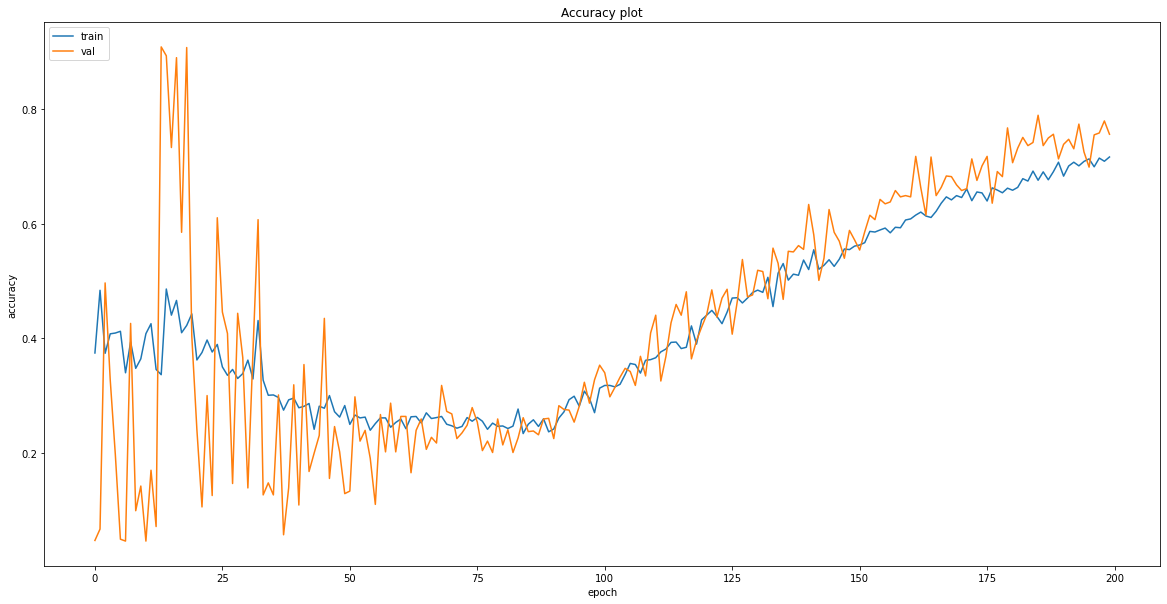

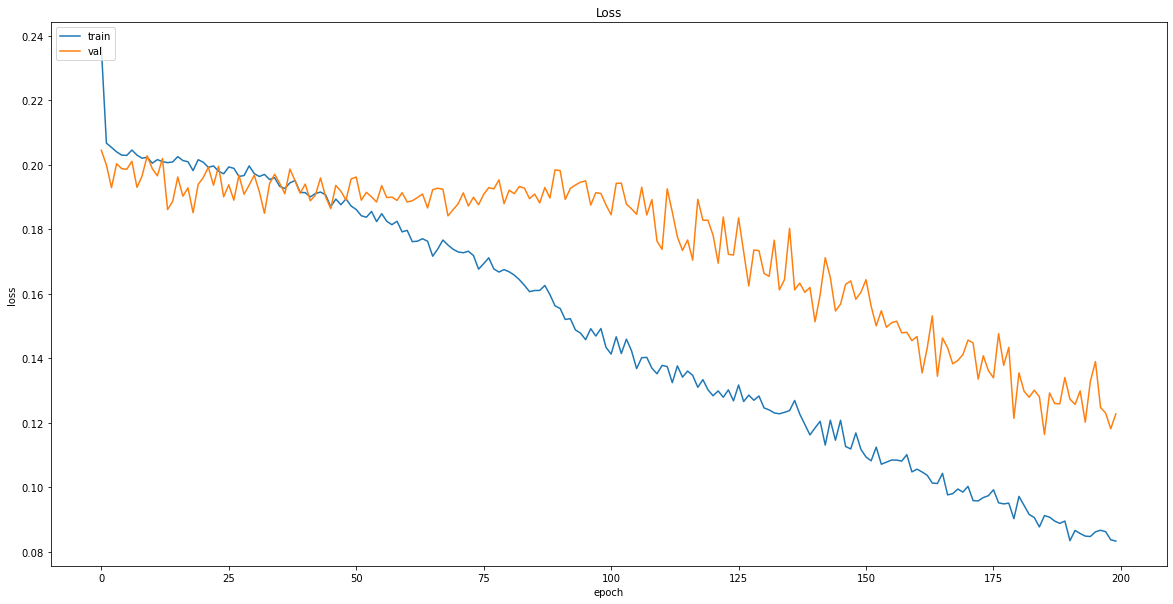

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
# Save model
model.save("models/{}".format('600779.SS_image_cnn_buy_hold_sell.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/600779.SS_image_cnn_buy_hold_sell.model\assets


### Wuliangye Yibin Co.,Ltd (Mid Cap)

In [28]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/000858.SZ_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
1  2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2  2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
3  2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
4  2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


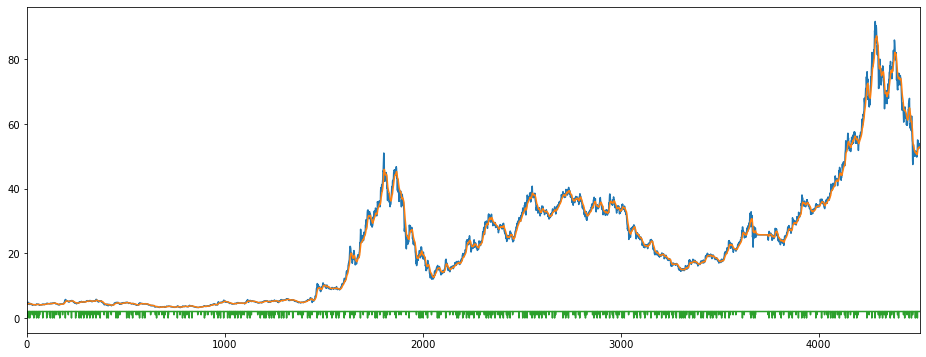

In [29]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [30]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-24,4.396951,4.259450,-20.237909,91957609.0,2.0
2000-01-25,4.523540,4.300079,-16.033642,115224048.0,2.0
2000-01-26,4.400991,4.315604,-35.231971,105394663.0,2.0
2000-01-27,4.399644,4.328533,-51.735021,77180955.0,2.0
2000-01-28,4.302682,4.324556,-63.091500,43145413.0,2.0


In [31]:
# willr_data = []
# price_data = []
# ema_data = []
# obv_data = []
# labels = []
# data_15_price = []
# data_15_willr = []
# data_15_ema = []
# data_15_obv = []
# count = 0

# for i in df.values:
#     if count == 14:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         price_data.append(data_15_price)
#         willr_data.append(data_15_willr)
#         ema_data.append(data_15_ema)
#         obv_data.append(data_15_obv)
#         labels.append(i[-1])
#         data_15_price = data_15_price[1:]
#         data_15_willr = data_15_willr[1:]
#         data_15_obv = data_15_obv[1:]
#         data_15_ema = data_15_ema[1:]
    
#     else:
#         data_15_price.append([i[0]])
#         data_15_ema.append([i[1]])
#         data_15_willr.append([i[2]])
#         data_15_obv.append([i[3]])
#         count += 1

In [32]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [33]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [35]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4498, 64, 64, 1)

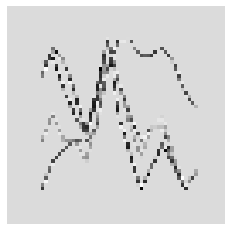

In [36]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [37]:
X = X/255

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.639065817409766, 1: 7.449275362318841, 2: 0.36565040650406505}
Epoch 1/200
29/29 [==============================] - 2s 53ms/step - loss: 0.2500 - accuracy: 0.4619 - mse: 1.5846 - weighted_accuracy: 0.3386 - weighted_mse: 1.6339 - val_loss: 0.2005 - val_accuracy: 0.6456 - val_mse: 0.8210 - val_weighted_accuracy: 0.6456 - val_weighted_mse: 0.8210
Epoch 2/200
29/29 [==============================] - 0s 8ms/step - loss: 0.2168 - accuracy: 0.4742 - mse: 1.1244 - weighted_accuracy: 0.3089 - weighted_mse: 1.1891 - val_loss: 0.1987 - val_accuracy: 0.5333 - val_mse: 0.8294 - val_weighted_accuracy: 0.5333 - val_weighted_mse: 0.8294
Epoch 3/200
29/29 [==============================] - 0s 8ms/step - loss: 0.2163 - accuracy: 0.4250 - mse: 1.0773 - weighted_accuracy: 0.3336 - weighted_mse: 1.1046 - val_loss: 0.1819 - val_accuracy: 0.8811 - val_mse: 1.0477 - val_weighted_accuracy: 0.8811 - val_weighted_mse: 1.0477
Epoch 4/200
29/29 [==============================] - 0s 8ms/step - loss: 0.2128 -

29/29 [==============================] - 0s 8ms/step - loss: 0.1944 - accuracy: 0.2582 - mse: 1.2205 - weighted_accuracy: 0.4232 - weighted_mse: 1.1995 - val_loss: 0.1913 - val_accuracy: 0.1633 - val_mse: 1.0649 - val_weighted_accuracy: 0.1633 - val_weighted_mse: 1.0649
Epoch 29/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1938 - accuracy: 0.2165 - mse: 1.1513 - weighted_accuracy: 0.4535 - weighted_mse: 1.1638 - val_loss: 0.1894 - val_accuracy: 0.1811 - val_mse: 0.9559 - val_weighted_accuracy: 0.1811 - val_weighted_mse: 0.9559
Epoch 30/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1945 - accuracy: 0.2257 - mse: 1.1818 - weighted_accuracy: 0.4186 - weighted_mse: 1.1627 - val_loss: 0.1898 - val_accuracy: 0.1033 - val_mse: 1.0598 - val_weighted_accuracy: 0.1033 - val_weighted_mse: 1.0598
Epoch 31/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1943 - accuracy: 0.2418 - mse: 1.1879 - weighted_accuracy: 0.4066 - weighted_mse: 1.1

Epoch 57/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1773 - accuracy: 0.1798 - mse: 1.2835 - weighted_accuracy: 0.5138 - weighted_mse: 1.2575 - val_loss: 0.1907 - val_accuracy: 0.1667 - val_mse: 1.1722 - val_weighted_accuracy: 0.1667 - val_weighted_mse: 1.1722
Epoch 58/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1757 - accuracy: 0.1859 - mse: 1.2239 - weighted_accuracy: 0.5417 - weighted_mse: 1.2030 - val_loss: 0.1899 - val_accuracy: 0.1700 - val_mse: 1.1494 - val_weighted_accuracy: 0.1700 - val_weighted_mse: 1.1494
Epoch 59/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1717 - accuracy: 0.1862 - mse: 1.3582 - weighted_accuracy: 0.5500 - weighted_mse: 1.3285 - val_loss: 0.1932 - val_accuracy: 0.1456 - val_mse: 1.0663 - val_weighted_accuracy: 0.1456 - val_weighted_mse: 1.0663
Epoch 60/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1735 - accuracy: 0.1776 - mse: 1.2990 - weighted_accuracy: 0.5490 - weig

Epoch 86/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1535 - accuracy: 0.2004 - mse: 1.4462 - weighted_accuracy: 0.6232 - weighted_mse: 1.4369 - val_loss: 0.1961 - val_accuracy: 0.1944 - val_mse: 1.3048 - val_weighted_accuracy: 0.1944 - val_weighted_mse: 1.3048
Epoch 87/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1550 - accuracy: 0.2004 - mse: 1.4374 - weighted_accuracy: 0.6095 - weighted_mse: 1.4335 - val_loss: 0.1953 - val_accuracy: 0.1800 - val_mse: 1.2429 - val_weighted_accuracy: 0.1800 - val_weighted_mse: 1.2429
Epoch 88/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1590 - accuracy: 0.1959 - mse: 1.3937 - weighted_accuracy: 0.6161 - weighted_mse: 1.3850 - val_loss: 0.1972 - val_accuracy: 0.1789 - val_mse: 1.2892 - val_weighted_accuracy: 0.1789 - val_weighted_mse: 1.2892
Epoch 89/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1527 - accuracy: 0.2065 - mse: 1.4388 - weighted_accuracy: 0.6258 - weig

Epoch 115/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.2877 - mse: 1.5796 - weighted_accuracy: 0.6677 - weighted_mse: 1.6524 - val_loss: 0.1877 - val_accuracy: 0.3033 - val_mse: 1.4433 - val_weighted_accuracy: 0.3033 - val_weighted_mse: 1.4433
Epoch 116/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1388 - accuracy: 0.2941 - mse: 1.5872 - weighted_accuracy: 0.6759 - weighted_mse: 1.6873 - val_loss: 0.1898 - val_accuracy: 0.2900 - val_mse: 1.4388 - val_weighted_accuracy: 0.2900 - val_weighted_mse: 1.4388
Epoch 117/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1366 - accuracy: 0.2857 - mse: 1.6354 - weighted_accuracy: 0.6950 - weighted_mse: 1.7206 - val_loss: 0.1865 - val_accuracy: 0.2989 - val_mse: 1.3932 - val_weighted_accuracy: 0.2989 - val_weighted_mse: 1.3932
Epoch 118/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1385 - accuracy: 0.3127 - mse: 1.5612 - weighted_accuracy: 0.6827 - 

Epoch 144/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1275 - accuracy: 0.3902 - mse: 1.7623 - weighted_accuracy: 0.7074 - weighted_mse: 2.0920 - val_loss: 0.1741 - val_accuracy: 0.4489 - val_mse: 1.5392 - val_weighted_accuracy: 0.4489 - val_weighted_mse: 1.5392
Epoch 145/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1255 - accuracy: 0.4152 - mse: 1.7414 - weighted_accuracy: 0.7343 - weighted_mse: 2.0207 - val_loss: 0.1734 - val_accuracy: 0.4656 - val_mse: 1.4963 - val_weighted_accuracy: 0.4656 - val_weighted_mse: 1.4963
Epoch 146/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1265 - accuracy: 0.4133 - mse: 1.7401 - weighted_accuracy: 0.7377 - weighted_mse: 2.0318 - val_loss: 0.1768 - val_accuracy: 0.4033 - val_mse: 1.5111 - val_weighted_accuracy: 0.4033 - val_weighted_mse: 1.5111
Epoch 147/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1278 - accuracy: 0.4258 - mse: 1.7531 - weighted_accuracy: 0.7283 - 

Epoch 173/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1099 - accuracy: 0.5381 - mse: 1.9601 - weighted_accuracy: 0.7694 - weighted_mse: 2.7460 - val_loss: 0.1604 - val_accuracy: 0.5856 - val_mse: 1.6364 - val_weighted_accuracy: 0.5856 - val_weighted_mse: 1.6364
Epoch 174/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1095 - accuracy: 0.5395 - mse: 1.9790 - weighted_accuracy: 0.7937 - weighted_mse: 2.7865 - val_loss: 0.1599 - val_accuracy: 0.5911 - val_mse: 1.7654 - val_weighted_accuracy: 0.5911 - val_weighted_mse: 1.7654
Epoch 175/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1138 - accuracy: 0.5292 - mse: 1.9952 - weighted_accuracy: 0.7502 - weighted_mse: 2.7891 - val_loss: 0.1599 - val_accuracy: 0.5878 - val_mse: 1.6681 - val_weighted_accuracy: 0.5878 - val_weighted_mse: 1.6681
Epoch 176/200
29/29 [==============================] - 0s 8ms/step - loss: 0.1075 - accuracy: 0.5420 - mse: 2.0397 - weighted_accuracy: 0.7986 - 

In [43]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14708133041858673
Test accuracy: 0.6722221970558167


In [44]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-1.7192779  -0.53288734 -0.3405193 ]
 [-1.8657889  -0.54989326 -0.40701768]
 [-0.6392789  -1.5749305  -0.39977086]
 ...
 [-0.18089497 -2.293539   -0.61405975]
 [-0.334867   -2.0480719  -0.5413643 ]
 [-0.81085664 -1.2734619  -0.31387126]]


Counter({2: 646, 1: 120, 0: 134})

In [45]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 821, 0: 39, 1: 40})

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 900
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 33
actual sells but predicted buy: 0
actual predicted sells: 13
actual sells but predicted hold: 26
actual holds but predicted buy: 115
actual holds but predicted sell: 119
actual predicted holds: 587
Percentage buys correct: 12.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 71.49817295980512%
actual buys: 40
actual sells: 39
actual holds: 821


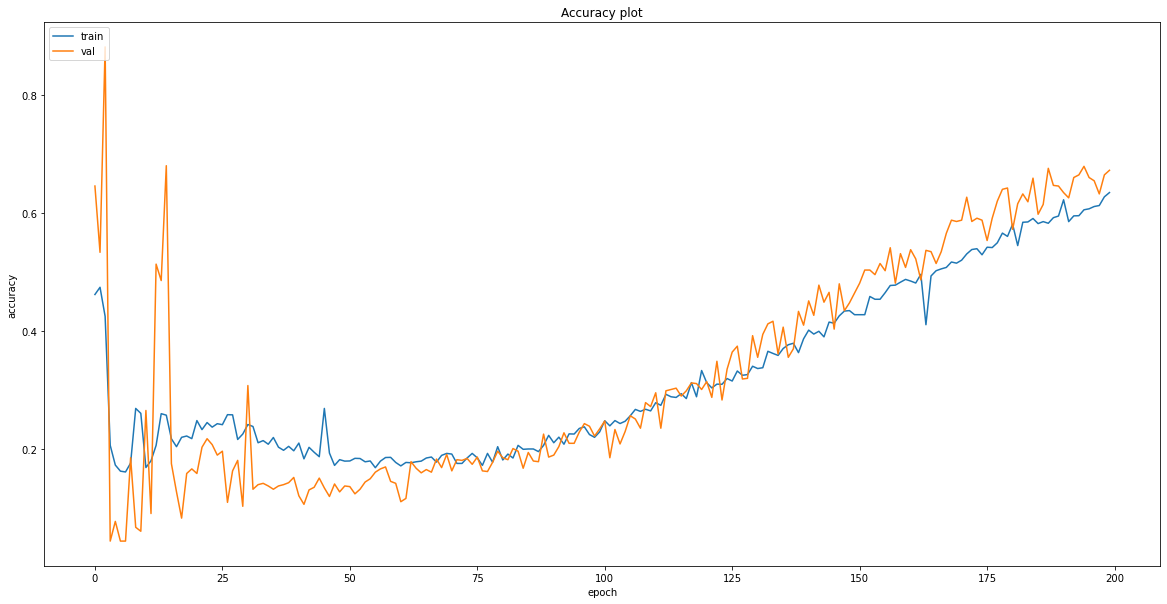

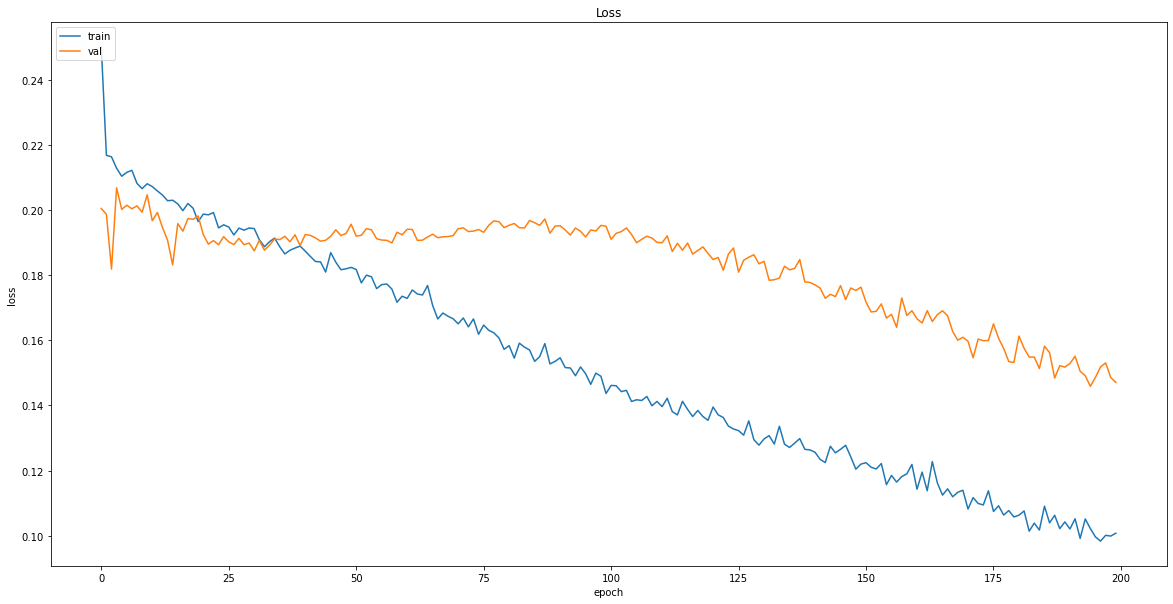

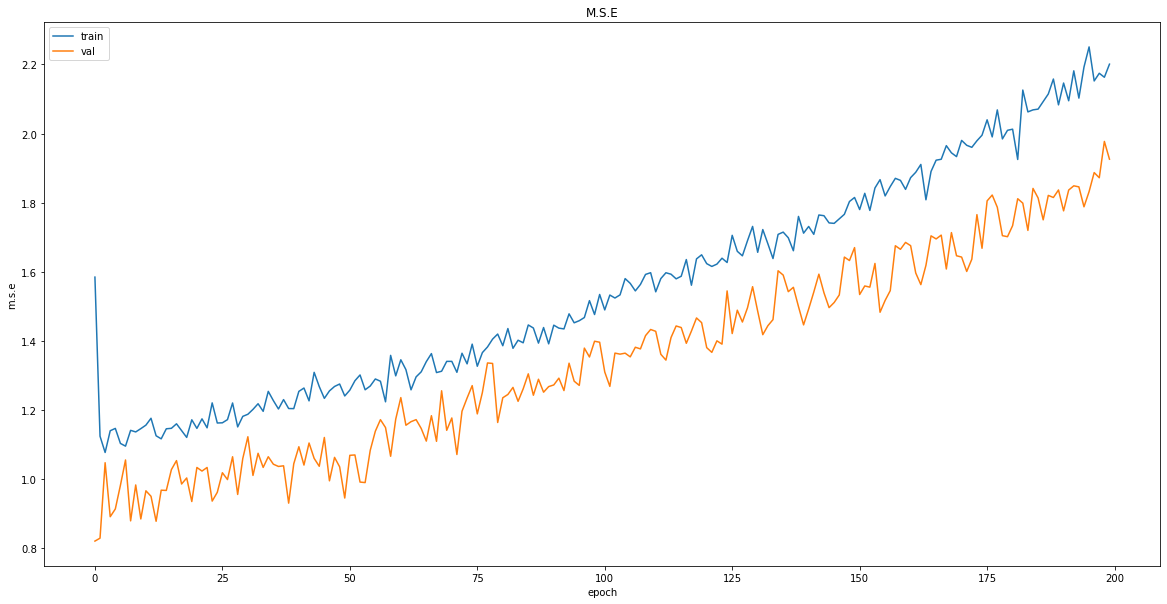

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [48]:
# Save model
model.save("models/{}".format('000858.SZ_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/000858.SZ_image_cnn_buy_hold_sell.model\assets


## Kweichow Moutai Co., Ltd (Large Cap)

In [49]:
seed = 10
df = pd.read_csv("data/variation 7/initial_indicators/600519.SS_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14        OBV_7  labels
0  2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
1  2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2  2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
3  2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
4  2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


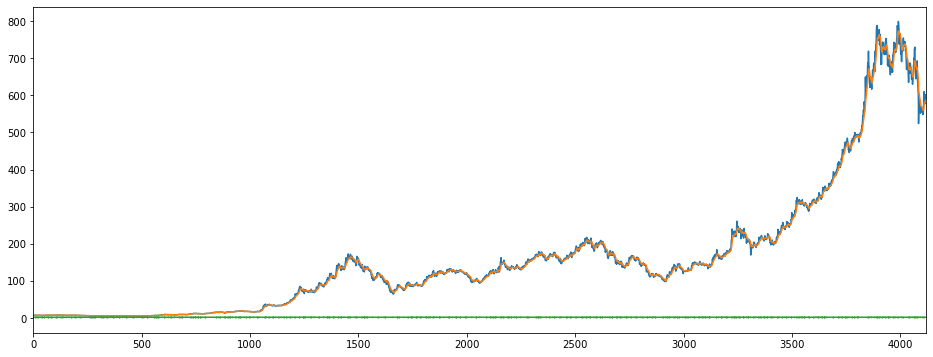

In [50]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2001-09-14,7.142585,7.257483,-41.873824,204624213.0,2.0
2001-09-17,7.224180,7.252359,-51.296847,208479649.0,2.0
2001-09-18,7.132634,7.233940,-72.964156,203965392.0,2.0
2001-09-19,7.214230,7.230908,-59.609037,209378730.0,2.0
2001-09-20,7.347568,7.248855,-37.785092,213725440.0,2.0


In [52]:
willr_data = []
price_data = []
ema_data = []
obv_data = []
labels = []
data_15_price = []
data_15_willr = []
data_15_ema = []
data_15_obv = []
count = 0

for i in df.values:
    if count == 14:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_price_arr = min_max_scaler.fit_transform(data_15_price)
        data_15_ema_arr = min_max_scaler.fit_transform(data_15_ema)
        data_15_willr_arr = min_max_scaler.fit_transform(data_15_willr)
        data_15_obv_arr = min_max_scaler.fit_transform(data_15_obv)
        price_data.append(data_15_price_arr)
        willr_data.append(data_15_willr_arr)
        ema_data.append(data_15_ema_arr)
        obv_data.append(data_15_obv_arr)
        labels.append(i[-1])
        data_15_price = data_15_price[1:]
        data_15_willr = data_15_willr[1:]
        data_15_obv = data_15_obv[1:]
        data_15_ema = data_15_ema[1:]
    
    else:
        data_15_price.append([i[0]])
        data_15_ema.append([i[1]])
        data_15_willr.append([i[2]])
        data_15_obv.append([i[3]])
        count += 1

In [53]:
willr_data = np.array(willr_data)
price_data = np.array(price_data)
ema_data = np.array(ema_data)
obv_data = np.array(obv_data)

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

sequential_data = []
    
for i in range(0,len(willr_data)):
    j = willr_data[i]
    k = price_data[i]
    l = ema_data[i]
    m = obv_data[i]
    fig, ax = plt.subplots()
    fig.set_size_inches((5,5))

    ax.plot(k)
    ax.plot(j)
    ax.plot(l)
    ax.plot(m)

    ax.axis('off')

    fig.add_axes(ax)
    fig.canvas.draw()

    # this rasterized the figure
    X = np.array(fig.canvas.renderer._renderer)
    X = 0.2989*X[:,:,1] + 0.5870*X[:,:,2] + 0.1140*X[:,:,3]
    X = cv2.resize(X, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)
    sequential_data.append(X)
    plt.close()

In [55]:
X = sequential_data
y = labels

X  = np.array(X).reshape(-1, 64, 64, 1)
y = np.array(y)

X.shape

(4106, 64, 64, 1)

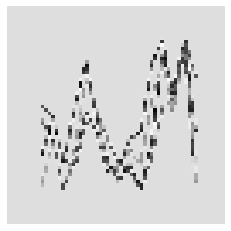

In [56]:
# plot the image array X
i = X[0].reshape(64, 64)
fig2, ax2 = plt.subplots()
plt.imshow(i, interpolation="none", cmap="gray")

ax2.axis('off')

plt.show()

In [57]:
X = X/255

In [58]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [59]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [60]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.3, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [62]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, validation_y),
    shuffle=True,
    callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.396396396396397, 1: 7.497716894977169, 2: 0.3661092530657748}
Epoch 1/200
26/26 [==============================] - 1s 57ms/step - loss: 0.2557 - accuracy: 0.3276 - mse: 1.7565 - weighted_accuracy: 0.3332 - weighted_mse: 1.8787 - val_loss: 0.1846 - val_accuracy: 0.7883 - val_mse: 0.9283 - val_weighted_accuracy: 0.7883 - val_weighted_mse: 0.9283
Epoch 2/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2060 - accuracy: 0.2780 - mse: 1.2499 - weighted_accuracy: 0.3440 - weighted_mse: 1.2425 - val_loss: 0.2013 - val_accuracy: 0.0450 - val_mse: 0.8905 - val_weighted_accuracy: 0.0450 - val_weighted_mse: 0.8905
Epoch 3/200
26/26 [==============================] - 0s 8ms/step - loss: 0.2069 - accuracy: 0.3398 - mse: 1.1795 - weighted_accuracy: 0.3248 - weighted_mse: 1.1893 - val_loss: 0.1948 - val_accuracy: 0.1861 - val_mse: 0.9766 - val_weighted_accuracy: 0.1861 - val_weighted_mse: 0.9766
Epoch 4/200
26/26 [==============================] - 0s 9ms/step - loss: 0.2043 - 

26/26 [==============================] - 0s 10ms/step - loss: 0.1995 - accuracy: 0.2661 - mse: 1.1983 - weighted_accuracy: 0.3759 - weighted_mse: 1.1732 - val_loss: 0.1925 - val_accuracy: 0.3114 - val_mse: 0.9016 - val_weighted_accuracy: 0.3114 - val_weighted_mse: 0.9016
Epoch 29/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1997 - accuracy: 0.2753 - mse: 1.1802 - weighted_accuracy: 0.3529 - weighted_mse: 1.1660 - val_loss: 0.1939 - val_accuracy: 0.2044 - val_mse: 0.9806 - val_weighted_accuracy: 0.2044 - val_weighted_mse: 0.9806
Epoch 30/200
26/26 [==============================] - 0s 10ms/step - loss: 0.1981 - accuracy: 0.2655 - mse: 1.2044 - weighted_accuracy: 0.3539 - weighted_mse: 1.1737 - val_loss: 0.2005 - val_accuracy: 0.0827 - val_mse: 0.9994 - val_weighted_accuracy: 0.0827 - val_weighted_mse: 0.9994
Epoch 31/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1986 - accuracy: 0.2555 - mse: 1.1612 - weighted_accuracy: 0.3438 - weighted_mse: 

Epoch 57/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1849 - accuracy: 0.1492 - mse: 1.2701 - weighted_accuracy: 0.4793 - weighted_mse: 1.2129 - val_loss: 0.1977 - val_accuracy: 0.0754 - val_mse: 1.0172 - val_weighted_accuracy: 0.0754 - val_weighted_mse: 1.0172
Epoch 58/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1838 - accuracy: 0.1602 - mse: 1.2532 - weighted_accuracy: 0.4897 - weighted_mse: 1.2085 - val_loss: 0.1964 - val_accuracy: 0.0912 - val_mse: 1.0290 - val_weighted_accuracy: 0.0912 - val_weighted_mse: 1.0290
Epoch 59/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1840 - accuracy: 0.1599 - mse: 1.2524 - weighted_accuracy: 0.4682 - weighted_mse: 1.2118 - val_loss: 0.1960 - val_accuracy: 0.0766 - val_mse: 1.0848 - val_weighted_accuracy: 0.0766 - val_weighted_mse: 1.0848
Epoch 60/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1832 - accuracy: 0.1477 - mse: 1.2713 - weighted_accuracy: 0.4918 - weig

Epoch 86/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1699 - accuracy: 0.1596 - mse: 1.3953 - weighted_accuracy: 0.5370 - weighted_mse: 1.3376 - val_loss: 0.1979 - val_accuracy: 0.1582 - val_mse: 1.1157 - val_weighted_accuracy: 0.1582 - val_weighted_mse: 1.1157
Epoch 87/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1691 - accuracy: 0.1550 - mse: 1.3919 - weighted_accuracy: 0.5419 - weighted_mse: 1.3468 - val_loss: 0.1967 - val_accuracy: 0.1436 - val_mse: 1.1580 - val_weighted_accuracy: 0.1436 - val_weighted_mse: 1.1580
Epoch 88/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1680 - accuracy: 0.1632 - mse: 1.3302 - weighted_accuracy: 0.5490 - weighted_mse: 1.2854 - val_loss: 0.1948 - val_accuracy: 0.1764 - val_mse: 1.2033 - val_weighted_accuracy: 0.1764 - val_weighted_mse: 1.2033
Epoch 89/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1676 - accuracy: 0.1629 - mse: 1.3799 - weighted_accuracy: 0.5489 - weig

Epoch 115/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1531 - accuracy: 0.2125 - mse: 1.5020 - weighted_accuracy: 0.6146 - weighted_mse: 1.5095 - val_loss: 0.1939 - val_accuracy: 0.2299 - val_mse: 1.3436 - val_weighted_accuracy: 0.2299 - val_weighted_mse: 1.3436
Epoch 116/200
26/26 [==============================] - 0s 8ms/step - loss: 0.1542 - accuracy: 0.2092 - mse: 1.5141 - weighted_accuracy: 0.6024 - weighted_mse: 1.5250 - val_loss: 0.1941 - val_accuracy: 0.2214 - val_mse: 1.3193 - val_weighted_accuracy: 0.2214 - val_weighted_mse: 1.3193
Epoch 117/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1543 - accuracy: 0.2065 - mse: 1.4543 - weighted_accuracy: 0.5822 - weighted_mse: 1.4578 - val_loss: 0.1914 - val_accuracy: 0.2725 - val_mse: 1.3718 - val_weighted_accuracy: 0.2725 - val_weighted_mse: 1.3718
Epoch 118/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1545 - accuracy: 0.2214 - mse: 1.5154 - weighted_accuracy: 0.6048 - 

Epoch 144/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1416 - accuracy: 0.2951 - mse: 1.7669 - weighted_accuracy: 0.6320 - weighted_mse: 1.8988 - val_loss: 0.1886 - val_accuracy: 0.3333 - val_mse: 1.4529 - val_weighted_accuracy: 0.3333 - val_weighted_mse: 1.4529
Epoch 145/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1415 - accuracy: 0.3039 - mse: 1.7097 - weighted_accuracy: 0.6330 - weighted_mse: 1.8712 - val_loss: 0.1859 - val_accuracy: 0.3297 - val_mse: 1.4732 - val_weighted_accuracy: 0.3297 - val_weighted_mse: 1.4732
Epoch 146/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1442 - accuracy: 0.2951 - mse: 1.6964 - weighted_accuracy: 0.6144 - weighted_mse: 1.8310 - val_loss: 0.1855 - val_accuracy: 0.3455 - val_mse: 1.4391 - val_weighted_accuracy: 0.3455 - val_weighted_mse: 1.4391
Epoch 147/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1460 - accuracy: 0.2972 - mse: 1.6939 - weighted_accuracy: 0.5917 - 

Epoch 173/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1313 - accuracy: 0.3989 - mse: 1.9734 - weighted_accuracy: 0.6764 - weighted_mse: 2.3200 - val_loss: 0.1735 - val_accuracy: 0.4611 - val_mse: 1.6491 - val_weighted_accuracy: 0.4611 - val_weighted_mse: 1.6491
Epoch 174/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1335 - accuracy: 0.4001 - mse: 1.9340 - weighted_accuracy: 0.6723 - weighted_mse: 2.1883 - val_loss: 0.1744 - val_accuracy: 0.4623 - val_mse: 1.6801 - val_weighted_accuracy: 0.4623 - val_weighted_mse: 1.6801
Epoch 175/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1335 - accuracy: 0.3873 - mse: 1.9840 - weighted_accuracy: 0.6398 - weighted_mse: 2.3474 - val_loss: 0.1747 - val_accuracy: 0.4574 - val_mse: 1.6561 - val_weighted_accuracy: 0.4574 - val_weighted_mse: 1.6561
Epoch 176/200
26/26 [==============================] - 0s 9ms/step - loss: 0.1345 - accuracy: 0.4041 - mse: 1.9649 - weighted_accuracy: 0.6653 - 

In [63]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.16044479608535767
Test accuracy: 0.5608272552490234


In [64]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.6491402  -1.099936   -0.43310332]
 [-0.5793777  -1.5013819  -0.44870636]
 [-1.5893459  -0.7308266  -0.37897265]
 ...
 [-0.96468025 -0.90982544 -0.3521849 ]
 [-0.2258015  -2.1289446  -0.62829745]
 [-2.260199   -0.10290638 -0.6195813 ]]


Counter({2: 467, 0: 214, 1: 141})

In [65]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 748, 1: 37, 0: 37})

In [66]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 822
actual predicted buys: 12
actual buys but predicted sell: 4
actual buys but predicted hold: 21
actual sells but predicted buy: 2
actual predicted sells: 19
actual sells but predicted hold: 16
actual holds but predicted buy: 127
actual holds but predicted sell: 191
actual predicted holds: 430
Percentage buys correct: 32.432432432432435%
Percentage sells correct: 51.351351351351354%
Percentage holds correct: 57.48663101604278%
actual buys: 37
actual sells: 37
actual holds: 748


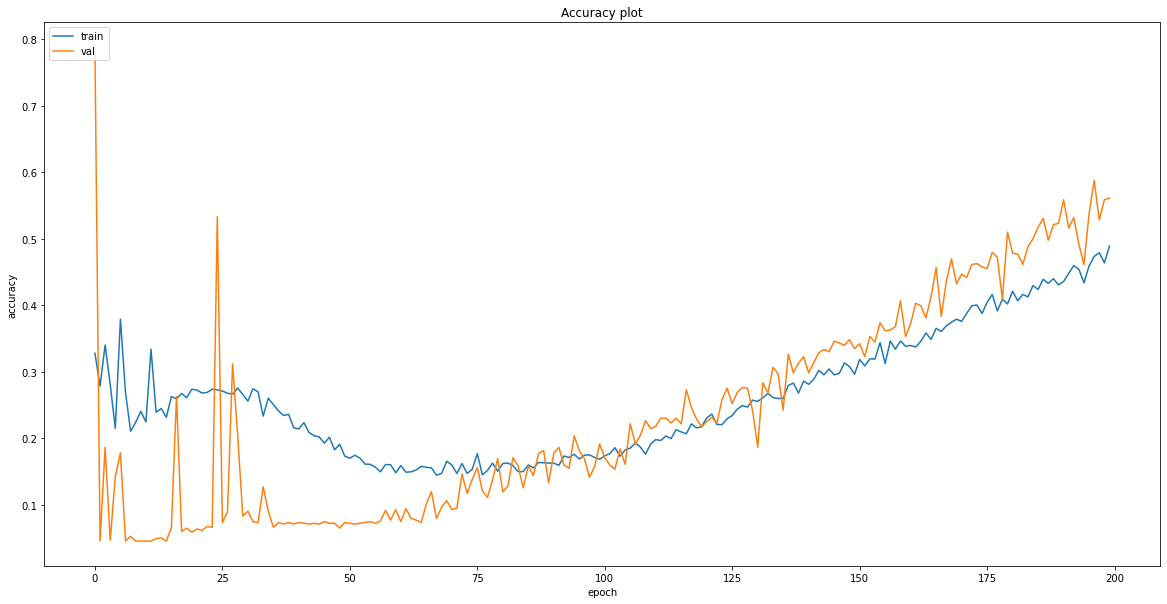

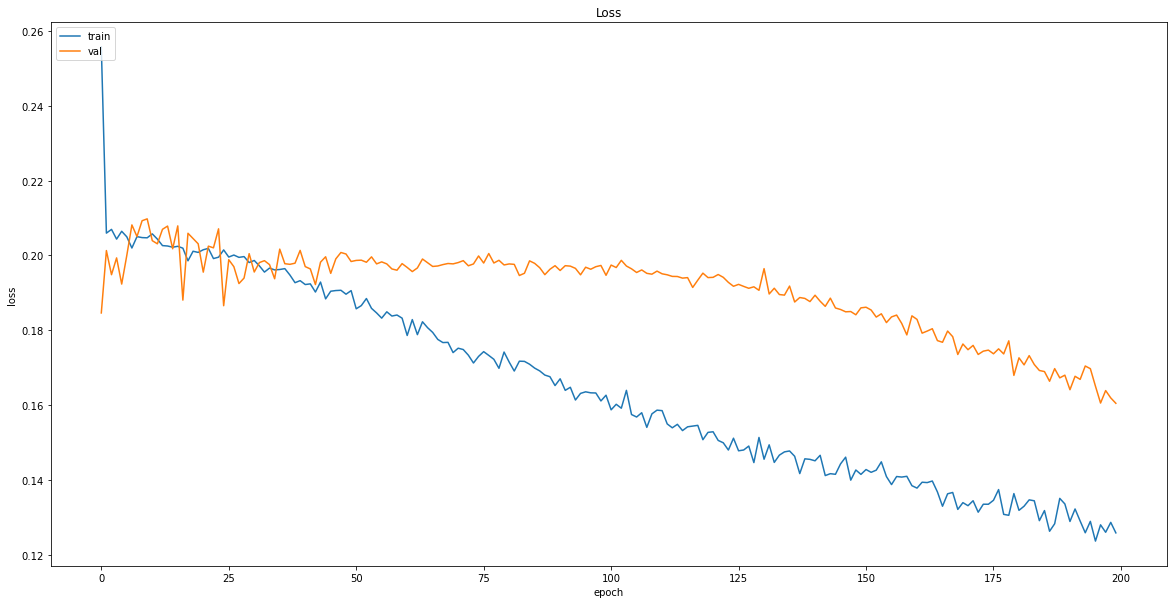

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
# Save model
model.save("models/{}".format('600519.SS_image_cnn_buy_hold_sell.model'))

INFO:tensorflow:Assets written to: models/600519.SS_image_cnn_buy_hold_sell.model\assets
